In [1]:
%pylab inline

import numpy as np
import scipy.sparse

from pyiga import bspline, hierarchical, assemble, geometry, solvers, vis

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Define the exact solution and right-hand side for the example problem.
#
# We use sympy to symbolically compute the Laplacian for the exact solution,
# so you may need to 'pip install sympy' to be able to run this notebook.
#
EXAMPLE = 1     # choose: 1 or 2

def generate_u_rhs(example):
    import sympy
    from sympy.abc import x, y, e
    from sympy.utilities.lambdify import lambdify
    
    # specify the manufactured solution
    if example == 1:
        r2 = (x-0.5)**2 + (y-0.5)**2
        u = x * (1-x) * y * (1-y) * sympy.sin(1 / (e + r2))
    elif example == 2:
        r = sympy.sqrt((x-0.5)**2 + (y-0.5)**2)
        denom = e + sympy.tanh(12*r - 7) - sympy.tanh(-7)
        u = x * (1-x) * y * (1-y) * sympy.sin(1 / denom)
    
    # symbolically compute the Laplacian for the right-hand side
    Lu = sympy.diff(u, x, x) + sympy.diff(u, y, y)
    return (lambdify((x, y, e), u, 'numpy'),
            lambdify((x, y, e), -Lu, 'numpy'))

sympy_u, sympy_rhs = generate_u_rhs(EXAMPLE)

dim = 2
eps = 1e-2
geo = geometry.unit_square()

def u_exact(x, y):
    return sympy_u(x, y, eps)

def rhs(x, y):
    return sympy_rhs(x, y, eps)

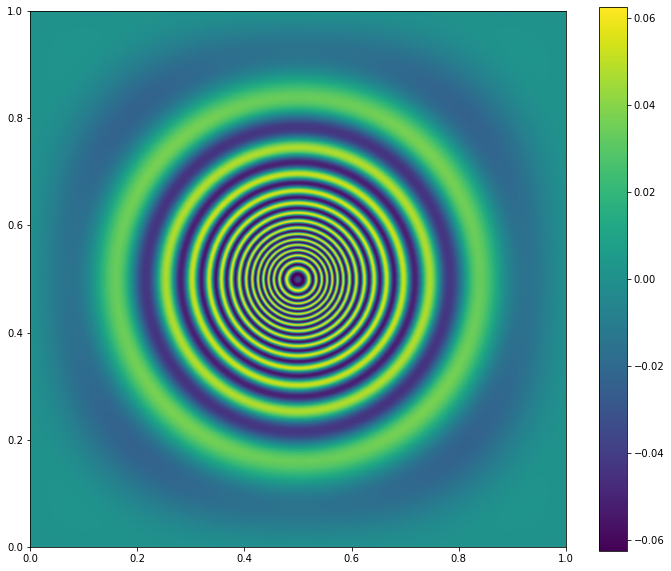

In [3]:
# plot the exact solution
figsize(12,10)
vis.plot_field(u_exact, geo=geo, res=600);
axis('scaled');
colorbar();

In [4]:
def doerfler_marking(errors, theta=0.9):
    """Given a list of errors, return a minimal list of indices such that the indexed
    errors have norm of at least theta * norm(errors)."""
    ix = np.argsort(errors)
    total = norm(errors)
    running = []
    marked = []
    for i in reversed(ix):
        running.append(errors[i])
        marked.append(i)
        if norm(running) >= theta * total:
            break
    return marked

In [5]:
plot_sol = True
plot_errors = True

def test_adaptive_method(p, n0, disparity, smoother, strategy, truncate=False, tol=1e-8, maxiter=4):
    # set up a one-level hierarchical spline space
    hs = hierarchical.HSpace(dim * (bspline.make_knots(p, 0.0, 1.0, n0),),
                             truncate=truncate, disparity=disparity,
                             bdspecs=['left', 'right', 'top', 'bottom'])
    
    # Create a second piecewise constant HSpace with the same mesh for the error
    # estimator. Each active function in this space is the characteristic function
    # for an active cell in hs.
    hs_p0 = hierarchical.HSpace(dim * (bspline.make_knots(0, 0.0, 1.0, n0),), disparity=np.inf)

    # keep track of errors for plotting
    numdofs, exacterrors = [], []

    # assembler parameters
    params = {'geo': geo, 'f': rhs, 'u_exact': u_exact}
    
    # compute L2 norm of the exact solution
    L2norm_u_exact = sqrt(assemble.assemble('u_exact**2 * v * dx',
                            2 * (bspline.make_knots(4, 0.0, 1.0, 200),), params).sum())

    for adapt_iter in range(maxiter):
        # ---------------------------------------------------------------------
        # SOLVE
        # ---------------------------------------------------------------------
        # assemble the problem
        A_hb = assemble.assemble('inner(grad(u), grad(v)) * dx', hs, params)
        f_hb = assemble.assemble('f * v * dx', hs, params)

        # solve using local multigrid
        u, iterations = solvers.solve_hmultigrid(hs, A_hb, f_hb, strategy, smoother)
        print('solved for', hs.numdofs, 'dofs in', iterations, 'iterations')
        
        # current solution as a hierarchical spline function
        u_sol = hierarchical.HSplineFunc(hs, u)
        
        # ---------------------------------------------------------------------
        # ESTIMATE
        # ---------------------------------------------------------------------
        # compute the residual error estimator and the error to the exact solution per active cell
        params['u_sol'] = u_sol
        err_estimator = assemble.assemble('(f + div(grad(u_sol)))**2 * v * dx', hs_p0, params)
        err_exact     = assemble.assemble('(u_sol - u_exact)**2 * v * dx', hs_p0, params)

        actcells = hs.active_cells(flat=True)   # list of (lv, cellidx) pairs
        h = array([2**(-lv) for (lv, _) in actcells])    # mesh size factor for each active cell
        err_estimator *= h**2     # scaling factor h^2 for error estimator

        if plot_errors:
            plt.figure(figsize=(14,6))
            plt.subplot(1, 2, 1)
            ax, p = vis.plot_active_cells(hs, err_estimator, cmap='cividis')
            #plt.colorbar(p, ax=ax);
            plt.axis('scaled')
            plt.title('Error estimator')
            plt.subplot(1, 2, 2)
            ax, p = vis.plot_active_cells(hs, err_exact, cmap='cividis')
            #plt.colorbar(p, ax=ax);
            plt.axis('scaled')
            plt.title('True error')
            plt.show()

        L2err = sqrt(err_exact.sum())
        relL2err = L2err / L2norm_u_exact
        print("Relative L2 error: {:.3e}".format(relL2err))
        
        numdofs.append(hs.numdofs)
        exacterrors.append(relL2err)
        
        if adapt_iter == maxiter - 1:
            break    # do not do any more refinement
        
        # ---------------------------------------------------------------------
        # MARK
        # ---------------------------------------------------------------------
        
        marked_cells = doerfler_marking(err_estimator, theta=0.9)
        
        # ---------------------------------------------------------------------
        # REFINE
        # ---------------------------------------------------------------------
        
        # convert marked cells to level-cell dict
        marked = {lv: set() for lv in range(hs.numlevels)}
        for k in marked_cells:
            marked[actcells[k][0]].add(actcells[k][1])

        num_marked = tuple(len(marked[lv]) for lv in range(hs.numlevels))
        num_cells = hs.total_active_cells
        
        if plot_sol:
            plt.figure(figsize=(14,6))
            plt.subplot(1, 2, 1)
            vis.plot_field(u_sol, geo=geo, res=400)
            plt.colorbar()
            plt.axis('scaled')
            plt.subplot(1, 2, 2)
            vis.plot_hierarchical_cells(hs, marked)
            plt.axis('scaled')
            plt.title('Marked cells')
            plt.show()

        # do the refinement
        refined = hs.refine(marked)
        hs_p0.refine(refined)    # keep P0 space in sync with the trial space
        
        # print statistics on marked/refined cells
        num_refined = tuple(len(refined[lv]) for lv in range(max(marked.keys()) + 1))
        print('Marked cells per level: {} ({:.1f}% of cells marked, {:.1f}% of cells refined)'.format(
            num_marked,
            100 * sum(num_marked) / num_cells,
            100 * sum(num_refined) / num_cells))

    # iteration has terminated - plot errors and return the solution
    if plot_sol:
        plt.figure(figsize=(6,6))
        plt.loglog(numdofs[2:], exacterrors[2:], 'o-')
        plt.xlabel('dofs')
        plt.ylabel('relative $L_2$ error')
        plt.show()
    return u_sol

solved for 169 dofs in 1 iterations


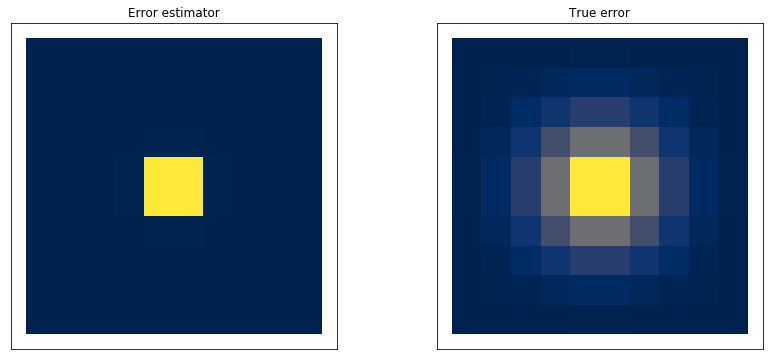

Relative L2 error: 1.575e+03


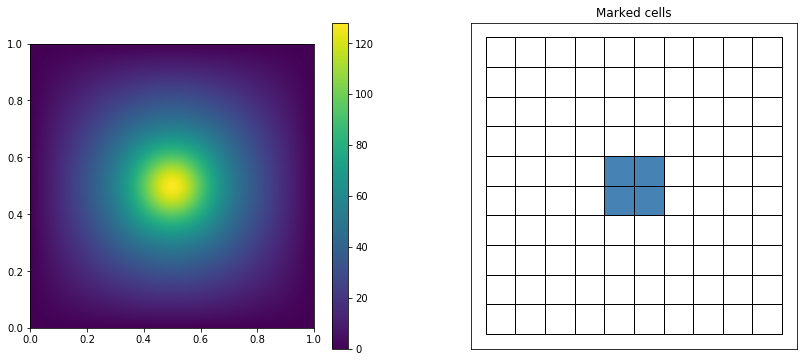

Marked cells per level: (4,) (4.0% of cells marked, 4.0% of cells refined)
solved for 170 dofs in 5 iterations


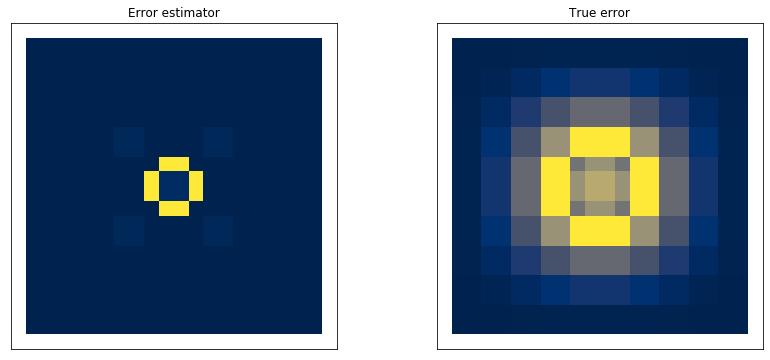

Relative L2 error: 1.564e+03


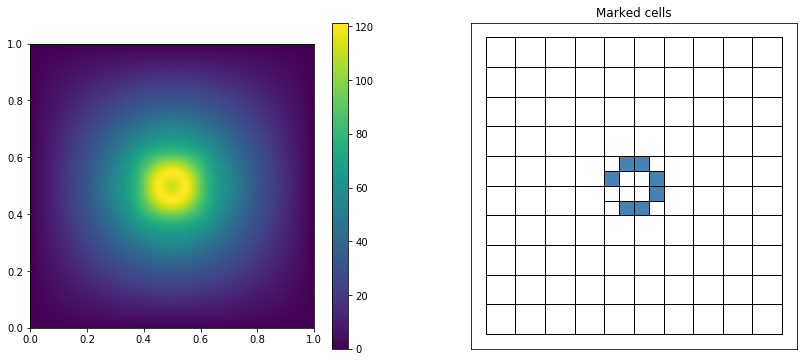

Marked cells per level: (0, 7) (6.2% of cells marked, 59.8% of cells refined)
solved for 313 dofs in 1 iterations


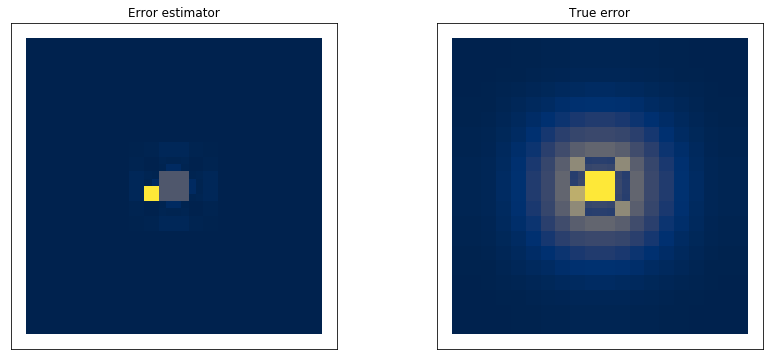

Relative L2 error: 3.767e+02


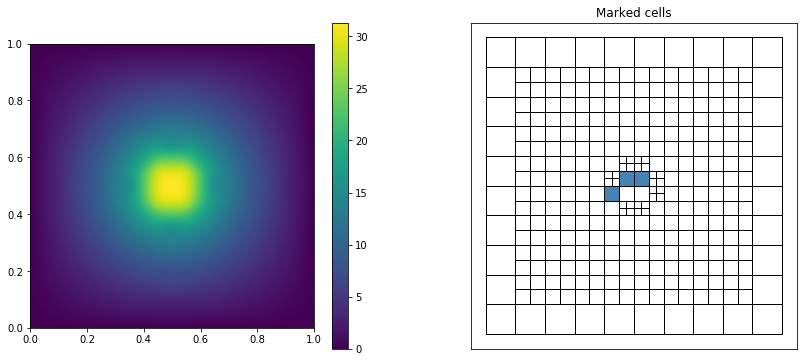

Marked cells per level: (0, 3, 0) (1.0% of cells marked, 1.0% of cells refined)
solved for 314 dofs in 5 iterations


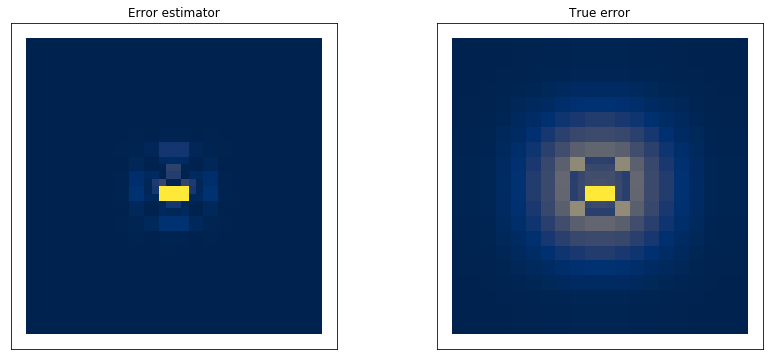

Relative L2 error: 3.764e+02


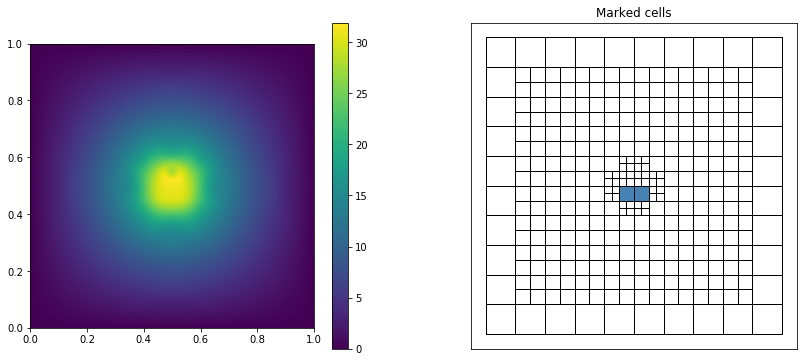

Marked cells per level: (0, 2, 0) (0.6% of cells marked, 0.6% of cells refined)
solved for 322 dofs in 5 iterations


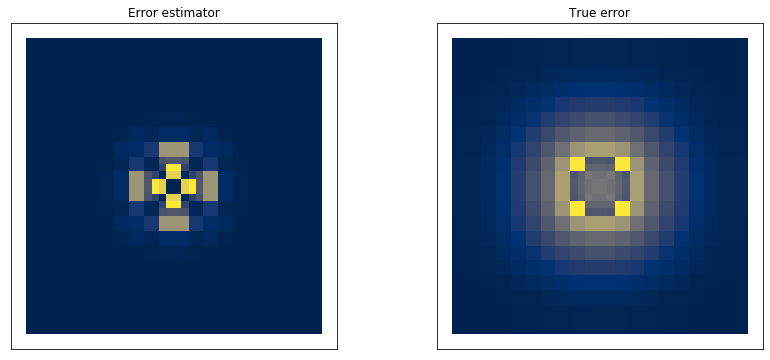

Relative L2 error: 3.762e+02


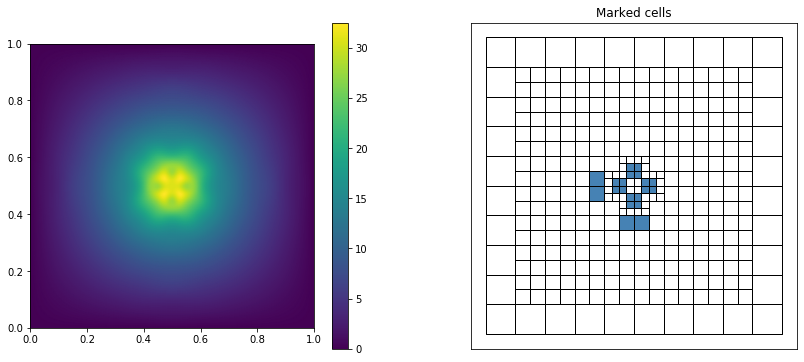

Marked cells per level: (0, 4, 16) (6.1% of cells marked, 41.5% of cells refined)
solved for 761 dofs in 5 iterations


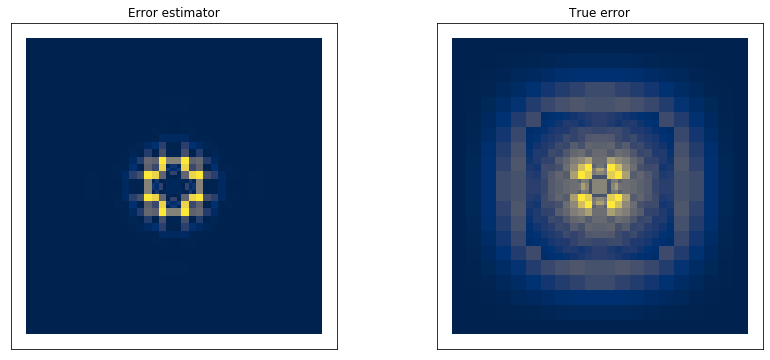

Relative L2 error: 1.715e+01


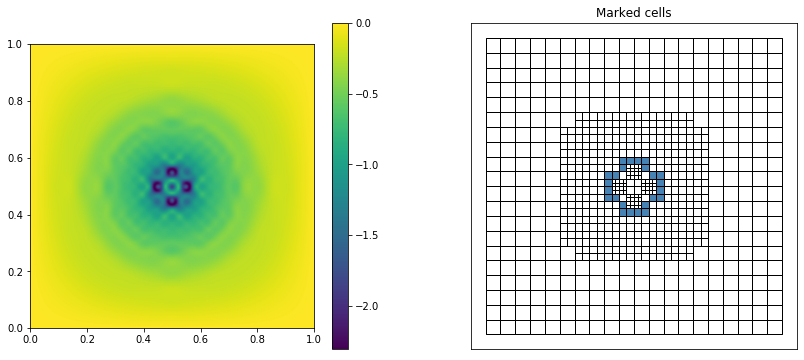

Marked cells per level: (0, 0, 24, 0) (3.3% of cells marked, 3.3% of cells refined)
solved for 785 dofs in 5 iterations


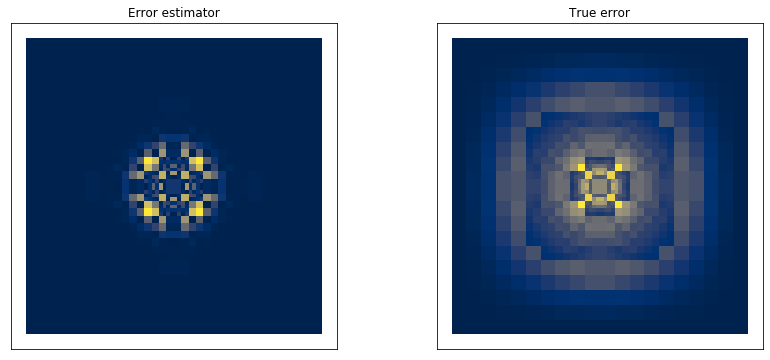

Relative L2 error: 1.716e+01


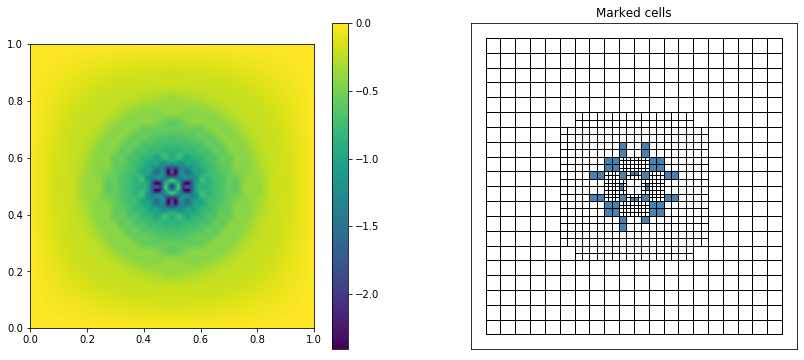

Marked cells per level: (0, 0, 35, 8) (5.3% of cells marked, 14.2% of cells refined)
solved for 1105 dofs in 6 iterations


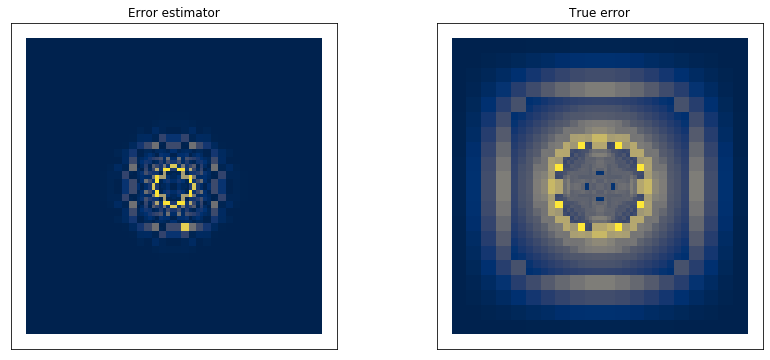

Relative L2 error: 1.981e+01


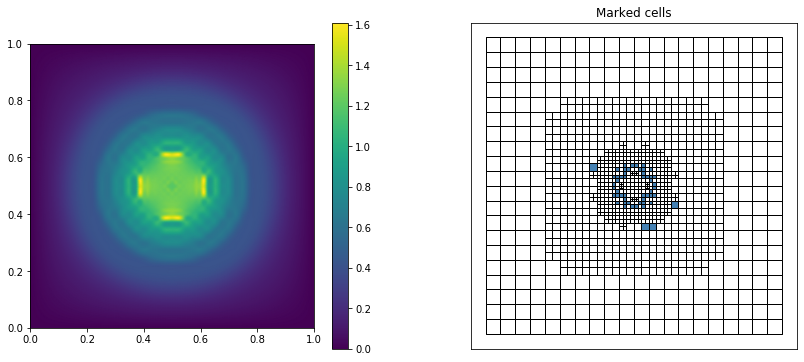

Marked cells per level: (0, 0, 4, 48, 0) (4.5% of cells marked, 8.1% of cells refined)
solved for 1249 dofs in 6 iterations


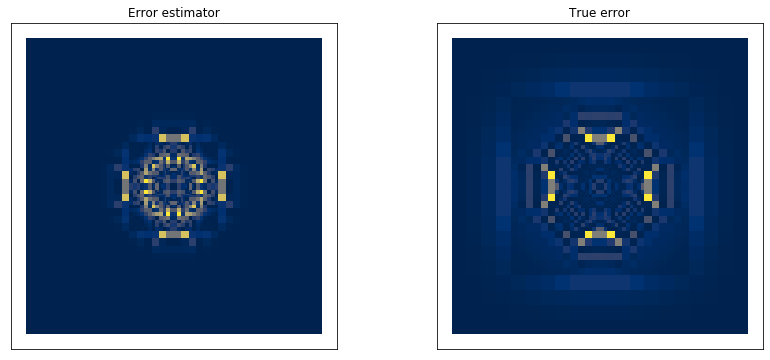

Relative L2 error: 1.425e+00


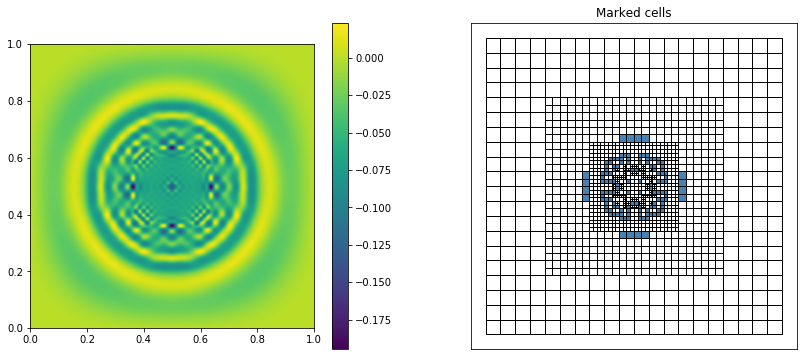

Marked cells per level: (0, 0, 16, 113, 0) (9.0% of cells marked, 17.9% of cells refined)
solved for 1681 dofs in 5 iterations


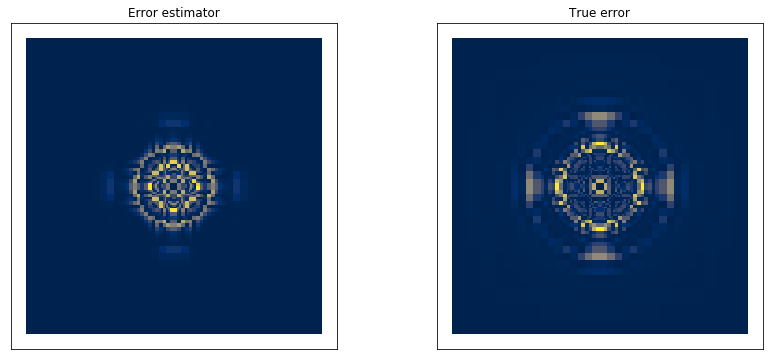

Relative L2 error: 5.752e-01


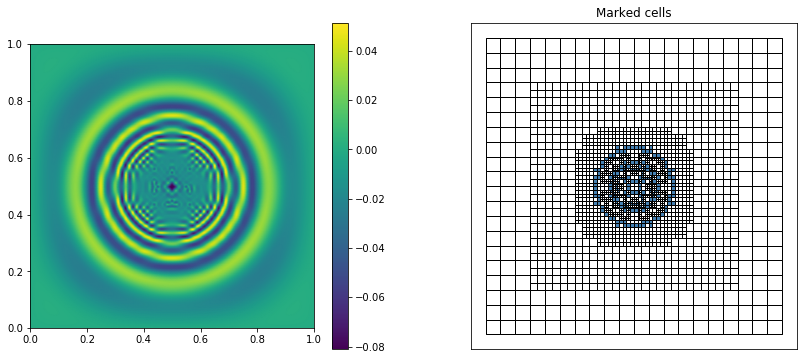

Marked cells per level: (0, 0, 0, 127, 106) (10.6% of cells marked, 19.5% of cells refined)
solved for 2923 dofs in 5 iterations


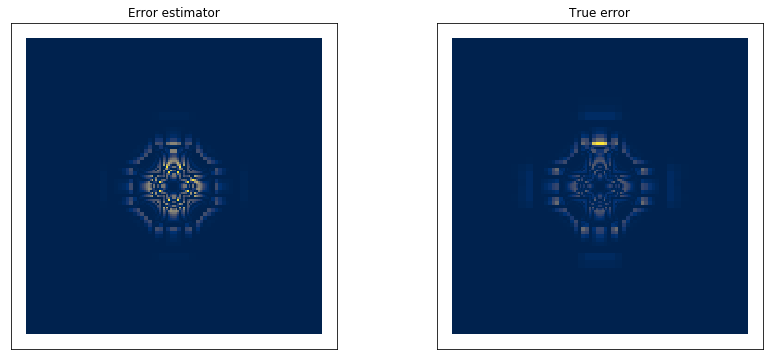

Relative L2 error: 4.034e-01


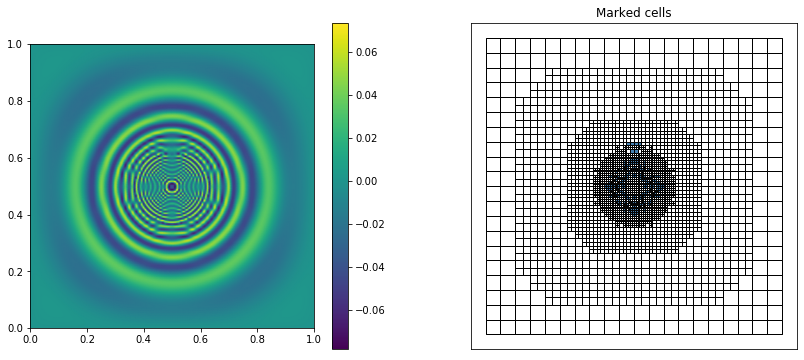

Marked cells per level: (0, 0, 0, 6, 222, 0) (6.5% of cells marked, 7.0% of cells refined)
solved for 3198 dofs in 5 iterations


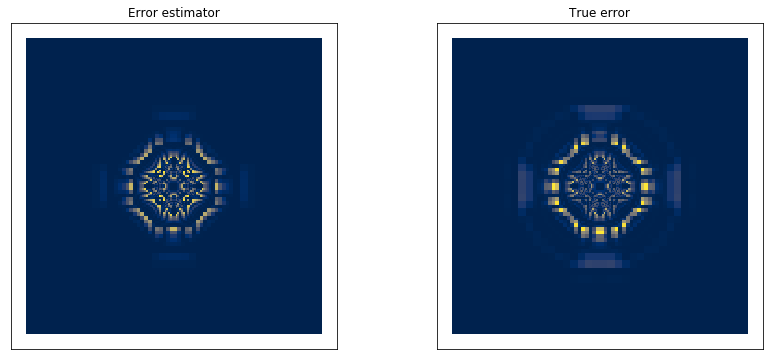

Relative L2 error: 3.139e-01


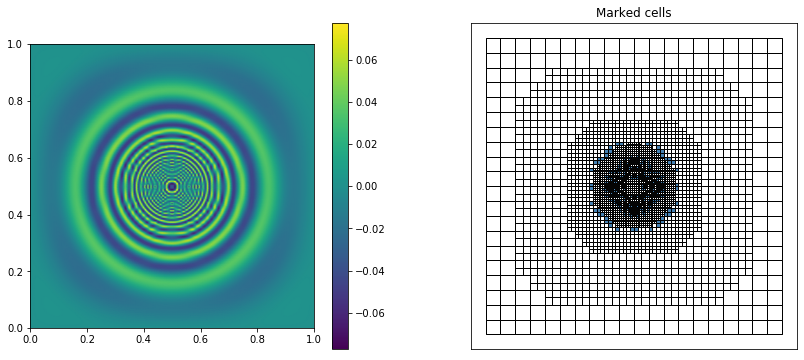

Marked cells per level: (0, 0, 0, 48, 201, 0) (5.9% of cells marked, 6.9% of cells refined)
solved for 3855 dofs in 5 iterations


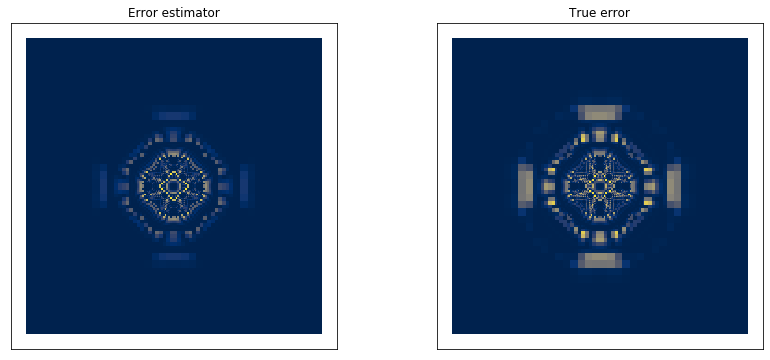

Relative L2 error: 2.149e-01


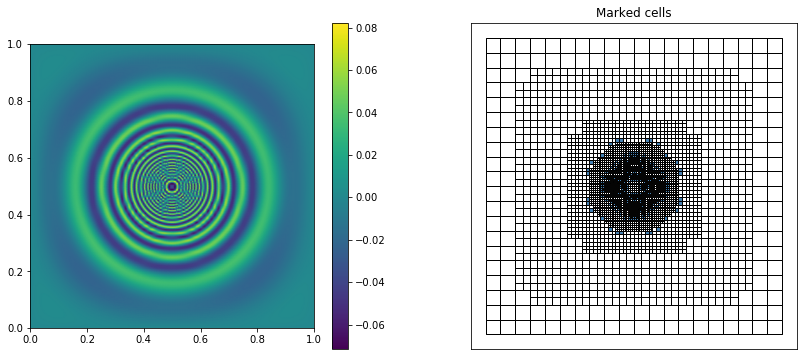

Marked cells per level: (0, 0, 0, 28, 232, 79) (6.6% of cells marked, 10.9% of cells refined)
solved for 5853 dofs in 5 iterations


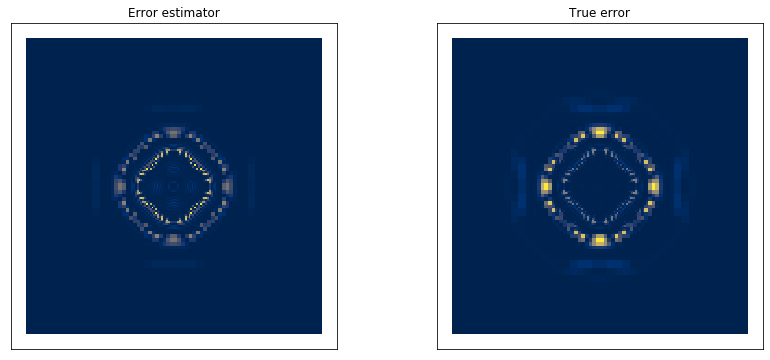

Relative L2 error: 7.160e-02


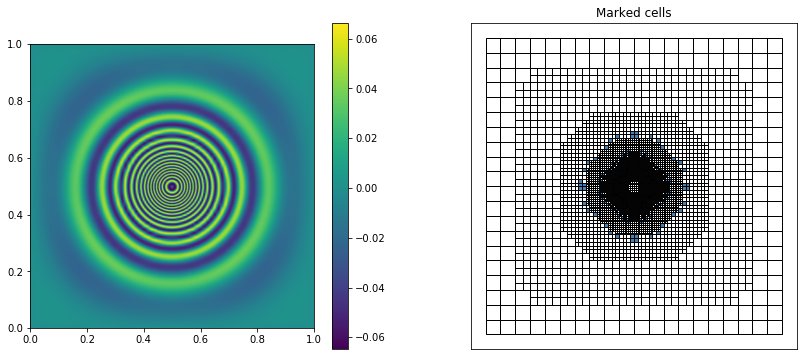

Marked cells per level: (0, 0, 0, 41, 104, 0, 0) (2.1% of cells marked, 3.6% of cells refined)
solved for 6233 dofs in 5 iterations


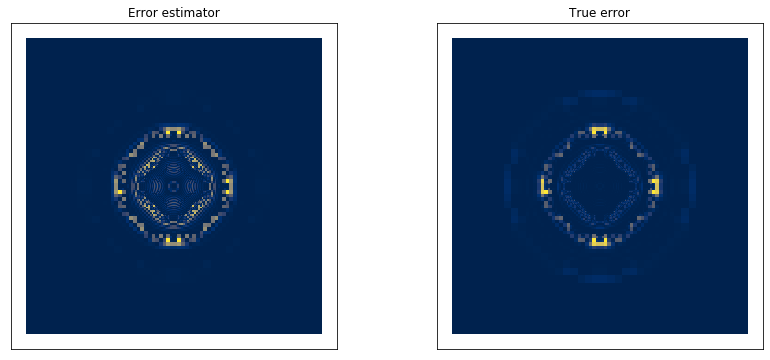

Relative L2 error: 5.547e-02


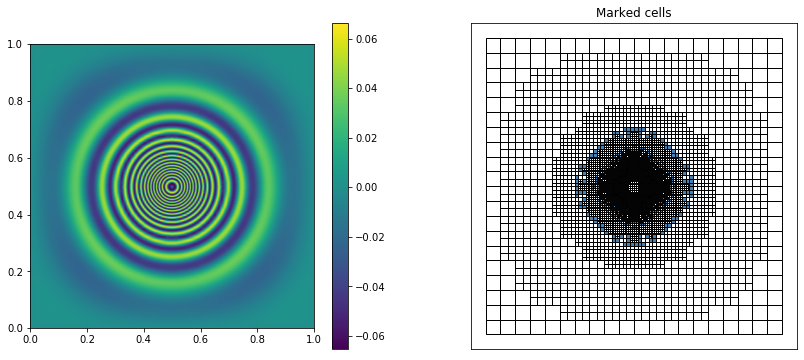

Marked cells per level: (0, 0, 0, 103, 212, 87, 0) (5.3% of cells marked, 7.3% of cells refined)
solved for 7889 dofs in 5 iterations


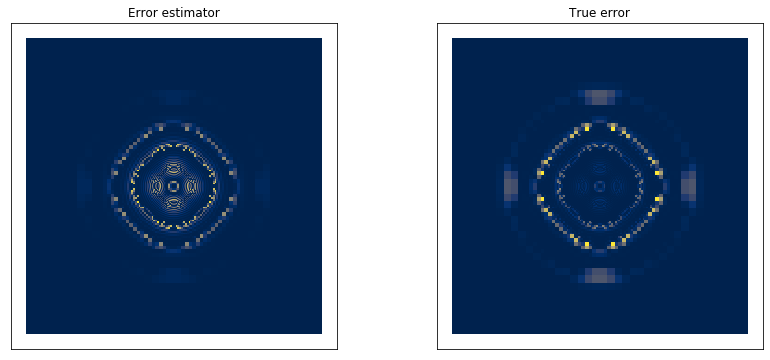

Relative L2 error: 2.042e-02


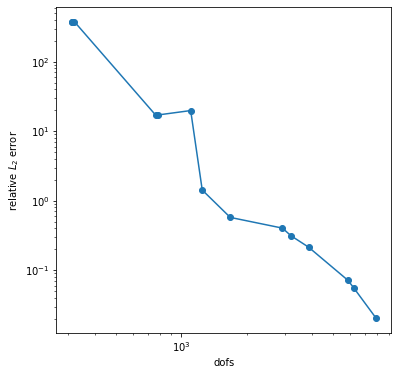

CPU times: user 1min 24s, sys: 3.02 s, total: 1min 27s
Wall time: 1min 13s


In [6]:
plot_sol = True
plot_errors = True

%time u_sol = test_adaptive_method(3, 10, 1, 'exact', 'cell_supp', truncate=False, maxiter=16)

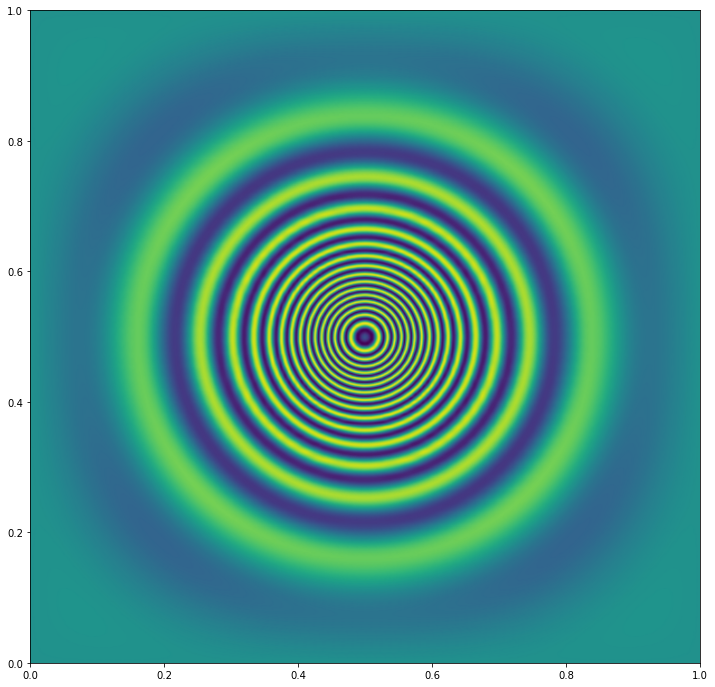

In [7]:
# plot the computed solution
figsize(12, 12)
vis.plot_field(u_sol, geo=geo, res=600);